micrograd from scratch2
=======================



## Imports



In [1]:
import math, random, time
import numpy as np
from matplotlib import pyplot as plt

rng = np.random.RandomState(2023)

## Return to the neuron model




![cs213n neuron model](./cs231n-neuron_model.jpg)

Ref: [cs231 neuron](https://cs231n.github.io/convolutional-networks/)

Let's consider the sort of activation functions that would be appropriate for a
neuron, using `tanh` in this example:

Recall the neuron that we created with the `tanh` activation function.


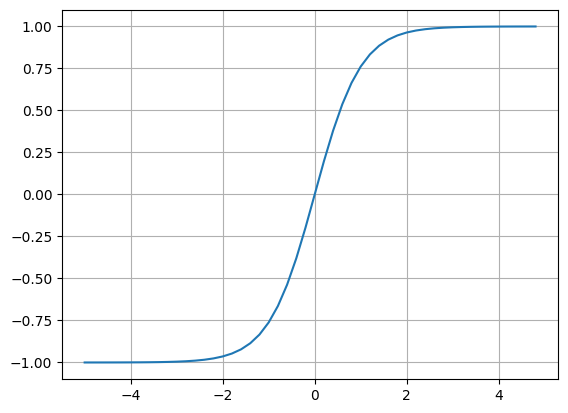

In [2]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

Let's bring back the object we used to contain the neuron's value. We have added
a few things since the last notebook:

-   added a `__pow__` function to handle exponentiation operator (`**`).
-   added a `__neg__` function to handle negation (`*-1`).
-   added a `__sub__` function to handle subtraction operator (`-`), via the
    negation function.
-   added a `__truediv__` function to handle division by multiplying by the inverse
-   added a few helper functions (`radd`, `rmul`, etc.) and statements that allow
    the `+` and `*` operators to work with raw scalars (instead of `Value`
    objects). If you don't believe me, return to the previous notebook and try to
    evaluate the following:

    `a = Value(2.0)`
    
    `2 * a`

    These "reverse" functions are something that Python and libraries take care of for you :)

In [3]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # apply chain rule for additive partial derivative
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            # apply chain rule for multiplicative partial derivative
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # apply derivative for tanh
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

Let's also bring back the `draw_dot` functionality:

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def get_variable_name(variable):
    globals_dict = globals()
    out =  [var_name for var_name in globals_dict if globals_dict[var_name] is variable]
    try:
        return out[0]
    except IndexError:
        return "~"

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left-to-right
    #dot.attr(bgcolor = "gray")

    nodes, edges = trace(root)
    for n in nodes:
        # for any value in the graph, create a rectangular ('record') for it
        dot.node(name=str(id(n)),
                 label = "{ %s | data %.4f | grad %.4f }" % (get_variable_name(n), n.data, n.grad),
                 shape='record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            # and connect this node to it
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

And let's bring back our non-linear neuron, except this time, we're going to
replace `tanh` with the atomic operations that comprise it. Essentially, we're
breaking it apart into discrete mathematical operations.



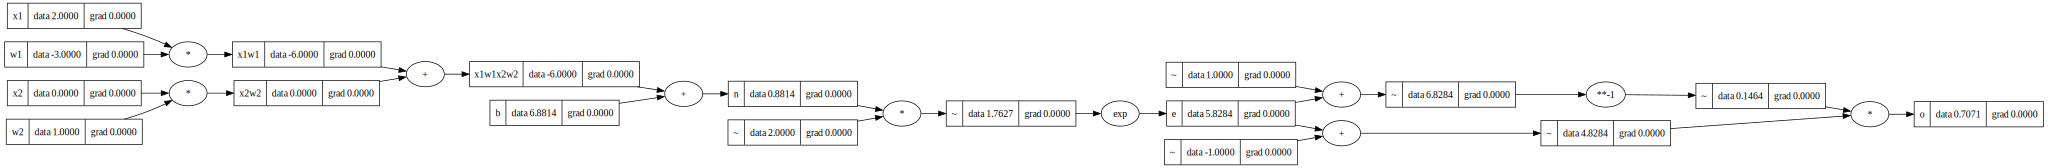

In [11]:
# inputs x1, x1
x1 = Value(2.0)
x2 = Value(0.0)
# weights w1, w2
w1 = Value(-3.0)
w2 = Value(1.0)
# bias of the neuron
b = Value(6.8813735870195432)
# the dot-product weighting that the neuron does
x1w1 = x1*w1
x2w2 = x2*w2
# the neuron
x1w1x2w2 = x1w1+x2w2
n = x1w1x2w2 + b
e = (2*n).exp()
o = (e - 1) / (e + 1)
draw_dot(o)

And call `o.backward()` and see the results.



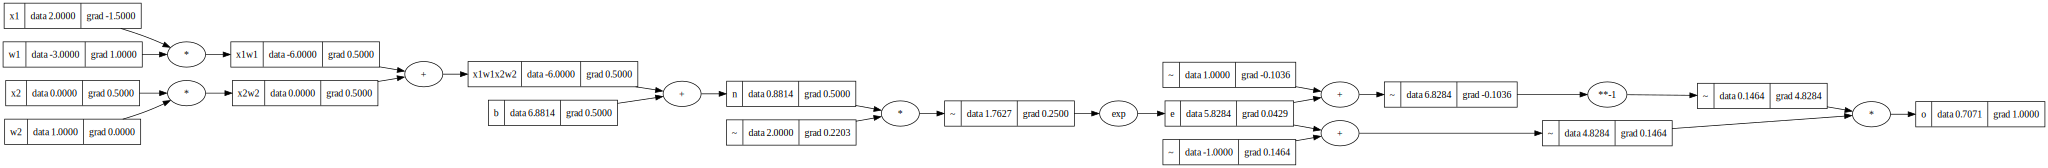

In [12]:
o.backward()
draw_dot(o)

The point here being that the level at which you implement your operations is up
to you. You can implement backward passes for tiny expressions (atomic `+` or
`-`) or for entire functions like `tanh`. All that matters is that we have some
kind of input and some kind of output and that the output is a function of the
input in some (hopefully principled) way.



## Using tensor objects



We're going to reproduce the above with the `PyTorch` API just going to show
that the above can be done with "production tools" just the same.



In [9]:
import torch
x1 = torch.Tensor([2.0]).double()                      ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                      ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                      ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()        ; b.requires_grad = True

n = x1*w1 +x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 1.0000002567688737


You see, we get the same values.

The benefit of using tensors is that we can create objects with multiple values,
say a multi-dimensional object (ECG values at one time stamp). Eg: `torch.Tensor([1,2,3],[4,5,6])`.

We can do the same thing that we did in `micrograd` with `pyTorch` as a special
case where the tensors are all single-element-tensors. The big deal with
`pyTorch` is that everything is *far* more efficient when dealing in
higher-dimensional spaces because we are using these tensor objects that both
keep track of the computational graph, and leverage hardware-specific
performance improvements to do lots of operations in parallel depending on if
you are using a CPU, a GPU, or a TPU.



## Building a neural network



Where "neural networks" are just a certain class of mathematical expressions.
Here, we are going to implement what is described as a multi-layer perception (MLP).

First, we define a single neuron that:

-   accepts a number of inputs `nin`
-   initializes some random weight between -1 and 1 for each input
-   initializes some random bias between -1 and 1
-   calling the neuron computes the dot product (aka weighted sum) if all the
    inputs, and passes this result into the `tanh` activation function to
    determine if the neuron "fires" or not



Value(data=-0.728061696443962)
Value(data=0.05269673524252161)


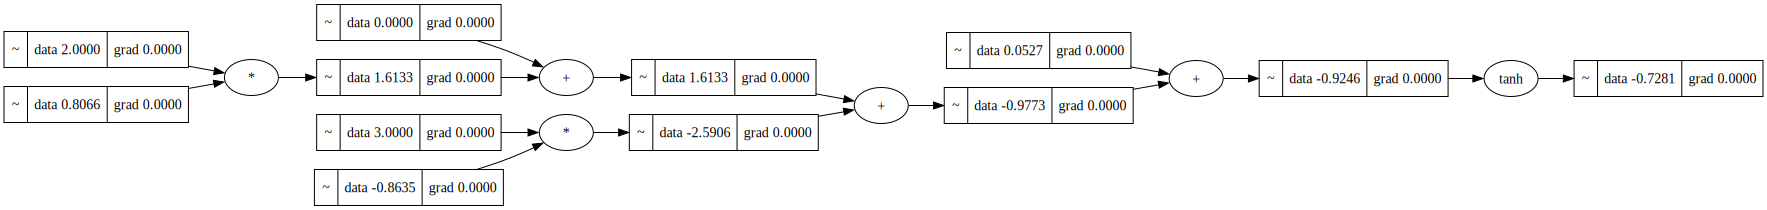

In [74]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(rng.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(rng.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x))) + self.b
        #n = sum(wi*xi for wi,xi in zip(self.w, x))
        #act = (n + self.b)
        return act.tanh()
x = [2.0, 3.0]
n = Neuron(2)
print(n(x))
print(n.b)
draw_dot(n(x))

Now we will define a "layer of neurons". Recall the schematic for a MLP. Each
hidden layer has a number of neurons that are not connected to each other, but
they are fully connected to the input (previous) layer. So a layer of neurons is
just a set of neurons evaluated independently. For example, let's create a
create a layer of 3 neurons that each are 2-dimensional.



In [76]:
class Layer():

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        #return outs

x = [2.0, 3.0]
n = Layer(2,3)
print(n(x))

[Value(data=-0.9811041547859566), Value(data=-0.6999001209213884), Value(data=-0.2615486649732573)]


Let's complete the picture and define an entire multi-layer perception (MLP).
Note from the schematic diagram, how the layers feed into each other,
sequentially. Let's recreate the diagram, where we have 2 input neurons, 2
layers of 4, and an output.



In [77]:
class MLP():

    def __init__(self, nin, nouts):  # nouts = the size of all of the layers
        sz = [nin] + nouts           # for each neuron (nin), tack on the size of the outputs
        # iterate over pairs of neurons and create a layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        # call each layer sequentally
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
print(m(x))

Value(data=-0.5218005531364852)


And we get one output value as one would expect. Now, we can `draw_dot` to see
what this would look like&#x2026; And we get a pretty involved looking object.



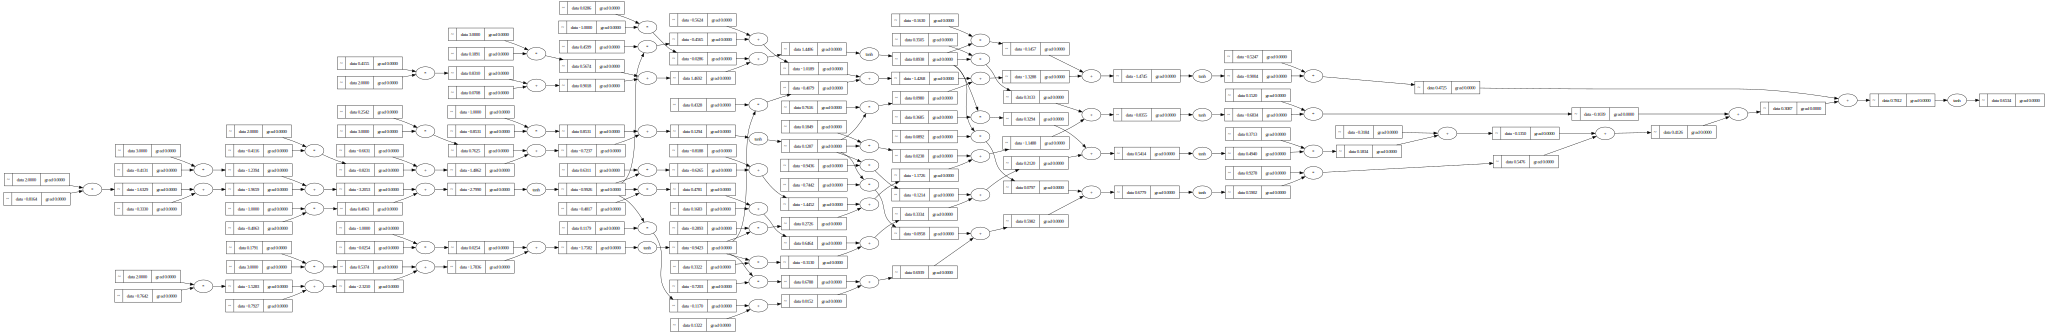

In [52]:
draw_dot(m(x))

Of course, we would never differentiate by hand an object like this, but with
micrograd we will be able to back-propagate through all of these.



## Training a neural net



Lets begin with a simple dataset with 4 inputs and 4 output targets. Basically,
we want the neural network to:

-   output `y=1.0` when `x = [2.0, 3.0, -1.0]`
-   output `y=-1.0` when `x = [3.0, -1.0, 0.5]`
-   output `y=1.0` when `x= [0.5, 1.0, -1.0]`
-   output `y=-1.0` when `x = [1.0, 1.0, -1.0]`

This is a simple binary classification. You can think of `y=1` as water being
present and `y=-1` as no water being present, and the x values being
reflectances in different spectral bands (say R, G, and B).



In [129]:
xs = [
[2.0, 3.0, -1.0],
[3.0, -1.0, 0.5],
[0.5, 1.0, -1.0],
[1.0, 1.0, -1.0],]
ys = [1.0, -1.0, -1.0, 1.0]

Let's see what the neural net currently thinks of these 4 examples.



In [130]:
rng = np.random.RandomState(2023)
ypred = [m(x) for x in xs]
print(ypred)

[Value(data=0.9461340481496999), Value(data=-0.9071768117366028), Value(data=-0.9064838455239912), Value(data=0.9169420472608324)]


These are the outputs of the neural net on the 4 examples.

-   We want the first output to be `1.0` but it is `0.88`
-   We want the second output to be `-1.0` but it is `-0.24`
-   We want the third output to be `-1.0` but it is `0.44`
-   We want the fourth output to be `1.0` but it is `0.01`

So how do we tune the weights to better predict the desired target? Well, we
want to compute a single number that determines the total performance of the
neural net and we call this number the *"loss"* (aka the error).



In [80]:
loss = sum ((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data=4.882439235507999)

Now, we want to minimize the loss. We want loss to be low, because if loss is
low then every prediction is equal to it's target. Now, if we run
`loss.backward()`, something magical happens.



In [81]:
loss.backward()
print(m.layers[0].neurons[0].w[0])
print(m.layers[0].neurons[0].w[0].grad)

Value(data=-0.006836425863106621)
0.3226171696625877


Remember from the previous notebook! We now see for the weight of the 1st neuron
in the first layer, we have it's gradient with respect to the loss. Since the
gradient is negative, we know that nudging the value of this neuron in the
positive direction would make the value of the loss go down. AND we have this
information for every single neuron in the network.

We can visualize this by the way (warning, very massive graph):



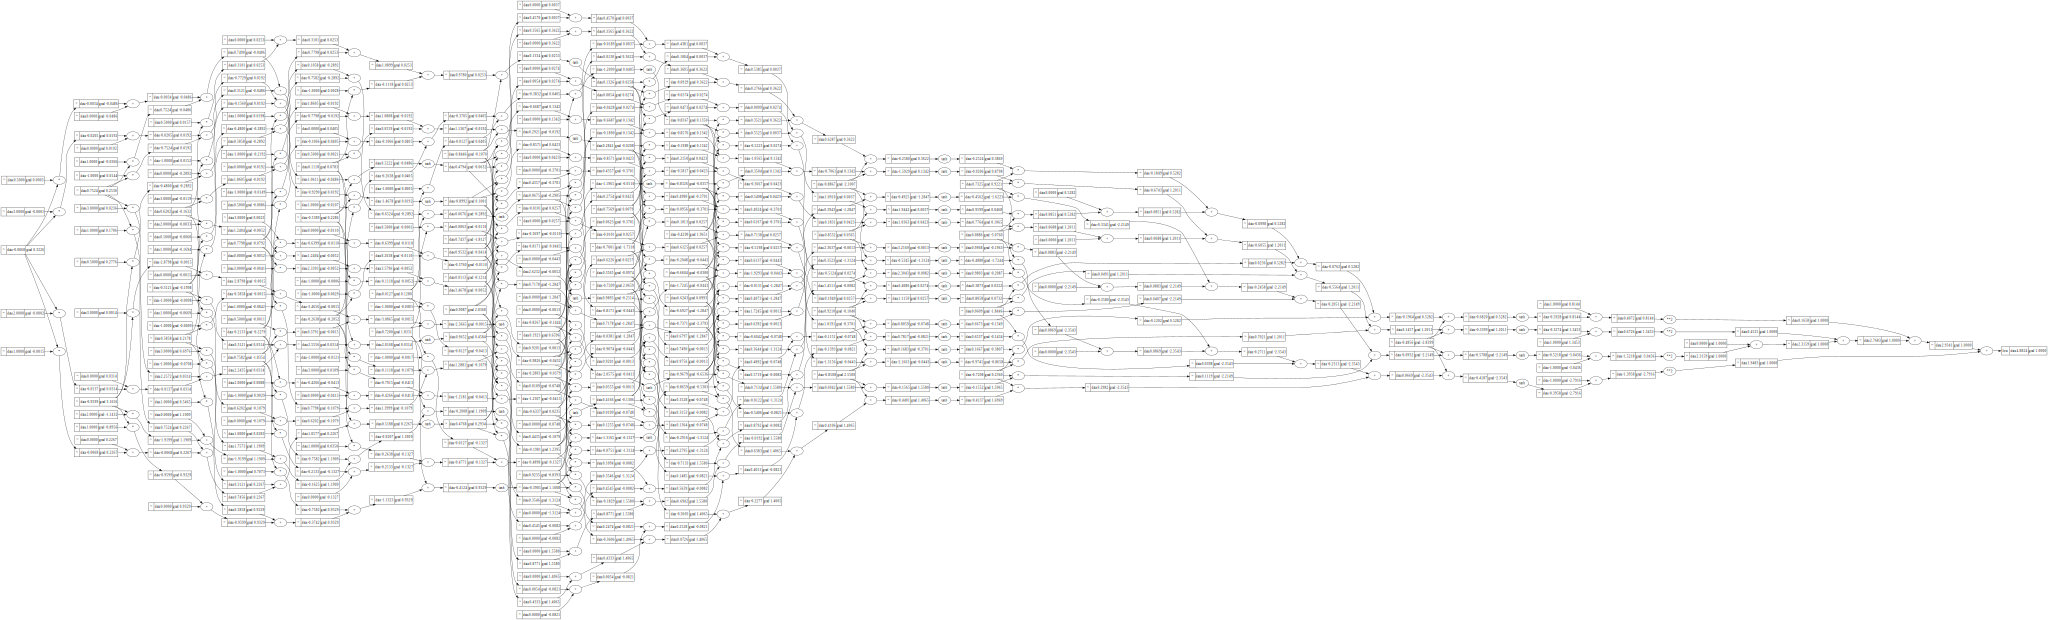

In [82]:
draw_dot(loss)

Note that we get gradients for every value in the net. All weights and biases,
even for the inputs! However, this is not as useful as our inputs are fixed&#x2013;we
can't really change them.

Now we're going to create some convenience code so that we can operate on all of
the parameters of the neural net. We want to nudge all of the values in the
direction of the gradient. We create a function to get the parameters from
`Neuron`, `Layer`, and `MLP`.



In [88]:
class Neuron:

    def __init__(self, nin):
        rng = np.random.RandomState(2022)
        self.w = [Value(rng.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(rng.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x))) + self.b
        return act.tanh()

    def parameters(self):
        return self.w + [self.b]
class Layer():

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP():

    def __init__(self, nin, nouts):  # nouts = the size of all of the layers
        sz = [nin] + nouts           # for each neuron (nin), tack on the size of the outputs
        # iterate over pairs of neurons and create a layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        # call each layer sequentally
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Then, we re-initialize our network.



In [89]:
x = [2.0, 3.0, -1]
m = MLP(3, [4, 4, 1])
print(m(x))

xs = [
[2.0, 3.0, -1.0],
[3.0, -1.0, 0.5],
[0.5, 1.0, -1.0],
[1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [m(x) for x in xs]
loss = sum ((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

Value(data=-0.9789230478907582)


In [90]:
len(m.parameters())

41

In [91]:
m.parameters()

[Value(data=-0.9812827723844706),
 Value(data=-0.0018843782960240585),
 Value(data=-0.7732326201303297),
 Value(data=-0.900051963644739),
 Value(data=-0.9812827723844706),
 Value(data=-0.0018843782960240585),
 Value(data=-0.7732326201303297),
 Value(data=-0.900051963644739),
 Value(data=-0.9812827723844706),
 Value(data=-0.0018843782960240585),
 Value(data=-0.7732326201303297),
 Value(data=-0.900051963644739),
 Value(data=-0.9812827723844706),
 Value(data=-0.0018843782960240585),
 Value(data=-0.7732326201303297),
 Value(data=-0.900051963644739),
 Value(data=-0.9812827723844706),
 Value(data=-0.0018843782960240585),
 Value(data=-0.7732326201303297),
 Value(data=-0.900051963644739),
 Value(data=0.37081518848618344),
 Value(data=-0.9812827723844706),
 Value(data=-0.0018843782960240585),
 Value(data=-0.7732326201303297),
 Value(data=-0.900051963644739),
 Value(data=0.37081518848618344),
 Value(data=-0.9812827723844706),
 Value(data=-0.0018843782960240585),
 Value(data=-0.7732326201303297),

In [92]:
ypred = [m(x) for x in xs]
loss = sum ((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
print(loss)

Value(data=7.829966752711949)


In [93]:
loss.backward()
for p in m.parameters():
    p.data += -0.01 * p.grad

In [94]:
ypred = [m(x) for x in xs]
print(ypred)

[Value(data=-0.9782266108276052), Value(data=-0.9783166623263475), Value(data=-0.9725498458947615), Value(data=-0.977328987674706)]


And, implementing a proper training loop would look like:



In [125]:
for k in range(20):
   # forward pass
    ypred = [m(x) for x in xs]
    loss = sum ((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

    # backward pass
    for p in m.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in m.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.033808987105029914
1 0.03340502584737471
2 0.033010069860369896
3 0.03262383058227079
4 0.03224603140608785
5 0.03187640707540327
6 0.031514703116089005
7 0.03116067530148385
8 0.030814089148767834
9 0.0304747194444507
10 0.03014234979704282
11 0.029816772215123678
12 0.029497786709154136
13 0.02918520091550027
14 0.028878829741247457
15 0.028578495028485446
16 0.02828402523684102
17 0.02799525514311991
18 0.02771202555699859
19 0.027434183051784054


In [126]:
ypred = [m(x) for x in xs]
print(ypred)

[Value(data=0.9461340481496999), Value(data=-0.9071768117366028), Value(data=-0.9064838455239912), Value(data=0.9169420472608324)]


## Footnotes

